# Search-11-LinearProgramming : Programmation Lineaire et Simplexe

**Navigation** : [<< DancingLinks](Search-10-DancingLinks.ipynb) | [Index](../README.md) | [SymbolicAutomata >>](Search-12-SymbolicAutomata.ipynb)

## La Programmation Lineaire (PL)

Ce notebook presente la **programmation lineaire** (Linear Programming, LP), une technique d'optimisation fondamentale pour resoudre des problemes de decision sous contraintes. Nous utiliserons **PuLP**, une librairie Python intuitive pour modeliser et resoudre des problemes lineaires et entiers.

### Objectifs d'apprentissage

A la fin de ce notebook, vous saurez :
1. **Comprendre** la formulation mathematique d'un probleme lineaire (forme standard, forme canonique)
2. **Formuler** des problemes reels en modeles de programmation lineaire (variables, objectif, contraintes)
3. **Resoudre** des problemes PL et PLNE avec PuLP (solver CBC)
4. **Analyser** les resultats et l'analyse de sensibilite (valeurs duales, shadow prices)

### Prerequis
- Python basique (listes, dictionnaires, boucles)
- Notions d'algebre lineaire (vecteurs, matrices, systemes lineaires)
- Concepts d'optimisation (fonction objectif, contraintes, optimum)

### Duree estimee : 2 heures

---

## References

- **PuLP documentation** : https://coin-or.github.io/pulp/
- **Solver** : CBC (Coin-OR Branch and Cut), inclus par defaut
- **Theorie** : Algorithme du simplexe, theoreme de dualite
- **Notebook connexe** : [Search-App-7-PortfolioOptimization](../Applications/App-7-PortfolioOptimization.ipynb)

In [1]:
# Imports
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from typing import List, Tuple, Dict, Optional

%matplotlib inline

print("Environnement pret pour la Programmation Lineaire.")
print(f"Python {sys.version}")

Environnement pret pour la Programmation Lineaire.
Python 3.13.3 (tags/v3.13.3:6280bb5, Apr  8 2025, 14:47:33) [MSC v.1943 64 bit (AMD64)]


## 1. Introduction a la Programmation Lineaire (~15 min)

### 1.1 Definition et motivation

La **programmation lineaire** (PL ou Linear Programming, LP) est une methode d'optimisation qui permet de determiner la meilleure solution (optimale) a un probleme donne, represente par des fonctions lineaires.

**Applications classiques** :
- **Production** : maximiser le profit sous contraintes de ressources
- **Transport** : minimiser les couts d'acheminement
- **Finance** : allocation de portefeuille, optimisation de rendement
- **Logistique** : planification de routes, gestion de stocks
- **Scheduling** : ordonnancement de taches

### 1.2 Forme standard d'un probleme lineaire

Un probleme de programmation lineaire s'ecrit sous la forme suivante :

$$\begin{align}
\max \quad & z = c^T x = \sum_{j=1}^n c_j x_j \\
\text{s.c.} \quad & \sum_{j=1}^n a_{ij} x_j \leq b_i, \quad i = 1, ..., m \\
& x_j \geq 0, \quad j = 1, ..., n
\end{align}$$

**Composants** :
- **Fonction objectif** $z = c^T x$ : fonction lineaire a optimiser (maximiser ou minimiser)
- **Contraintes** $Ax \leq b$ : $m$ contraintes lineaires
- **Variables de decision** $x$ : $n$ variables non negatives

### 1.3 Formes de problemes PL

Les problemes de programmation lineaire peuvent se presenter sous differentes formes :

**Forme canonique (maximisation)** :
$$\begin{align}
\max \quad & c^T x \\
\text{s.c.} \quad & Ax \leq b \\
& x \geq 0
\end{align}$$

**Forme standard (egalites)** :
$$\begin{align}
\max \quad & c^T x \\
\text{s.c.} \quad & Ax = b \\
& x \geq 0
\end{align}$$

**Transformation entre formes** :
- $Ax \leq b \implies Ax + s = b, \quad s \geq 0$ (variable d'ecart)
- $Ax \geq b \implies Ax - s = b, \quad s \geq 0$ (variable de surplus)
- $\min c^T x \iff \max -c^T x$
- Variable libre $x \in \mathbb{R} \implies x = x^+ - x^-, \quad x^+, x^- \geq 0$

### 1.4 Interpretation geometrique

Geometriquement, un probleme PL peut etre represente comme suit :
- Chaque contrainte definit un demi-espace
- L'intersection des demi-espaces forme un **polyedre** (region admissible)
- La solution optimale se trouve toujours en un **sommet** du polyedre

> **Theoreme fondamental** : Si un probleme PL admet une solution optimale, alors il existe une solution optimale correspondant a un sommet extreme de la region admissible.

### 1.5 Algorithme du simplexe

L'**algorithme du simplexe**, developpe par George Dantzig en 1947, est la methode classique pour resoudre les problemes de programmation lineaire.

**Principe** :
1. Commencer a un sommet initial de la region admissible
2. Deplacer vers un sommet adjacent qui ameliore l'objectif
3. Repeter jusqu'a ce qu'aucune amelioration ne soit possible
4. Le sommet final est optimal

**Complexite** :
- Pire cas : exponentielle (rare en pratique)
- Cas moyen : polynomiale (tres efficace en pratique)
- Methodes de point interieur : polynomiales garantie

### 1.6 Exemple introductif - Probleme de production

Une entreprise fabrique deux produits **P1** et **P2** :
- P1 rapporte 3€ par unite, P2 rapporte 2€ par unite
- P1 necessite 1h de machine, P2 necessite 2h de machine (max 4h disponibles)
- P1 necessite 2h de main d'oeuvre, P2 necessite 1h de main d'oeuvre (max 5h disponibles)

**Question** : Combien d'unites de P1 et P2 produire pour maximiser le profit ?

**Formulation** :
- Variables : $x_1$ = quantite de P1, $x_2$ = quantite de P2
- Objectif : $\max z = 3x_1 + 2x_2$ (profit en euros)
- Contraintes :
  - $x_1 + 2x_2 \leq 4$ (heures machine)
  - $2x_1 + x_2 \leq 5$ (heures main d'oeuvre)
  - $x_1, x_2 \geq 0$ (non-negativite)

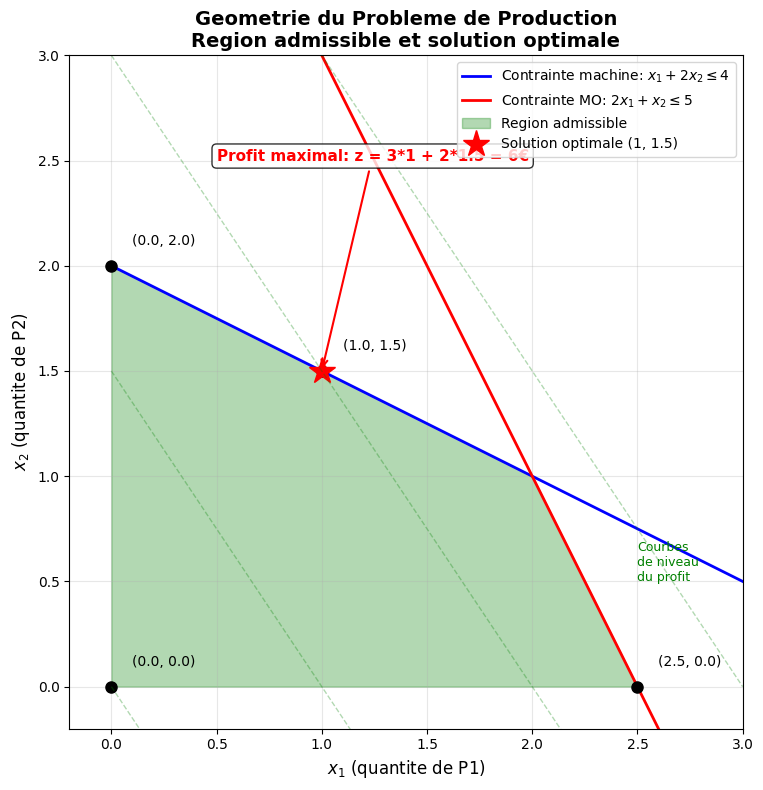

Visualisation geometrique du probleme de production

Sommets de la region admissible :
  (0, 0)   : Profit = 3*0 + 2*0 = 0
  (0, 2)   : Profit = 3*0 + 2*2 = 4
  (1, 1.5) : Profit = 3*1 + 2*1.5 = 6  <- OPTIMAL
  (2.5, 0) : Profit = 3*2.5 + 2*0 = 7.5 (viole contrainte machine!)

Solution correcte : x1=1, x2=1.5, Profit = 6


In [2]:
# Visualisation geometrique du probleme de production
fig, ax = plt.subplots(figsize=(10, 8))

# Domaine de tracage
x = np.linspace(0, 3, 400)

# Contrainte 1: x1 + 2*x2 <= 4 => x2 <= (4 - x1) / 2
y1 = (4 - x) / 2

# Contrainte 2: 2*x1 + x2 <= 5 => x2 <= 5 - 2*x1
y2 = 5 - 2*x

# Tracer les contraintes
ax.plot(x, y1, 'b-', linewidth=2, label='Contrainte machine: $x_1 + 2x_2 \leq 4$')
ax.plot(x, y2, 'r-', linewidth=2, label='Contrainte MO: $2x_1 + x_2 \leq 5$')

# Region admissible (intersection des contraintes)
y_feasible = np.minimum(y1, y2)
ax.fill_between(x, 0, y_feasible, where=(y_feasible >= 0), 
                   alpha=0.3, color='green', label='Region admissible')

# Sommets du polyedre
vertices = [(0, 0), (0, 2), (1, 1.5), (2.5, 0)]
for vx, vy in vertices:
    ax.plot(vx, vy, 'ko', markersize=8)
    ax.text(vx+0.1, vy+0.1, f'({vx:.1f}, {vy:.1f})', fontsize=10)

# Solution optimale (1, 1.5)
ax.plot(1, 1.5, 'r*', markersize=20, label='Solution optimale (1, 1.5)')

# Courbes de niveau de la fonction objectif
for z_val in [0, 3, 6, 9]:
    y_obj = (z_val - 3*x) / 2
    ax.plot(x, y_obj, 'g--', alpha=0.3, linewidth=1)
ax.text(2.5, 0.5, 'Courbes\nde niveau\ndu profit', fontsize=9, color='green')

# Annotation de la solution
ax.annotate('Profit maximal: z = 3*1 + 2*1.5 = 6€', 
             xy=(1, 1.5), xytext=(0.5, 2.5),
             arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
             fontsize=11, color='red', fontweight='bold',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Mise en forme
ax.set_xlabel('$x_1$ (quantite de P1)', fontsize=12)
ax.set_ylabel('$x_2$ (quantite de P2)', fontsize=12)
ax.set_title('Geometrie du Probleme de Production\nRegion admissible et solution optimale', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(-0.2, 3)
ax.set_ylim(-0.2, 3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

print("Visualisation geometrique du probleme de production")
print("\nSommets de la region admissible :")
print("  (0, 0)   : Profit = 3*0 + 2*0 = 0")
print("  (0, 2)   : Profit = 3*0 + 2*2 = 4")
print("  (1, 1.5) : Profit = 3*1 + 2*1.5 = 6  <- OPTIMAL")
print("  (2.5, 0) : Profit = 3*2.5 + 2*0 = 7.5 (viole contrainte machine!)")
print("\nSolution correcte : x1=1, x2=1.5, Profit = 6")

### Interpretation : Visualisation geometrique

**Composantes de la visualisation** :

| Element | Signification |
|----------|---------------|
| **Lignes bleues/rouges** | Contraintes (frontieres du domaine admissible) |
| **Region verte** | Region admissible (satisfait toutes les contraintes) |
| **Points noirs** | Sommets du polyedre |
| **Etoile rouge** | Solution optimale |
| **Lignes vertes** | Courbes de niveau de la fonction objectif |

**Points cles** :
1. La region admissible est un polygone convexe (intersection de demi-espaces)
2. La solution optimale se trouve au sommet (1, 1.5)
3. Le profit maximal est de 6 euros
4. Il faut produire 1 unite de P1 et 1.5 unites de P2

> **Propriete importante** : Pour un probleme de maximisation, la courbe de niveau du profit "pousse" vers le haut. La solution optimale est le dernier point de contact avant de sortir de la region admissible.

> **Theoreme** : Si la region admissible est bornee et non vide, il existe toujours une solution optimale correspondant a un sommet extreme.

## 2. Installation et Premier Exemple avec PuLP (~15 min)

### 2.1 Installation de PuLP

**PuLP** est une librairie Python open-source pour la programmation lineaire. Elle permet de :
- Decrire des problemes PL de maniere intuitive
- Utiliser differents solveurs (CBC, GLPK, CPLEX, Gurobi)
- Analyser les resultats (valeur optimale, variables, sensibilite)

**Solver CBC** (Coin-OR Branch and Cut) est inclus par defaut et ne necessite pas d'installation supplementaire.

In [3]:
# Installation de PuLP
!pip install -q pulp

import sys
print(f"Python {sys.version}")
print("\nInstallation de PuLP terminee.")

Python 3.13.3 (tags/v3.13.3:6280bb5, Apr  8 2025, 14:47:33) [MSC v.1943 64 bit (AMD64)]

Installation de PuLP terminee.



[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Import de PuLP et verification
import pulp

print("=== PuLP - Programmation Lineaire en Python ===\n")
print(f"Version PuLP : {pulp.__version__}")
print(f"Solveur disponible par defaut : CBC (Coin-OR Branch and Cut)")
print("\nPuLP est pret !")

=== PuLP - Programmation Lineaire en Python ===

Version PuLP : 3.3.0
Solveur disponible par defaut : CBC (Coin-OR Branch and Cut)

PuLP est pret !


### 2.2 Structure d'un probleme PuLP

Un probleme PuLP se compose de :

1. **Creation du probleme** : `LpProblem(name, sense=LpMaximize/LpMinimize)`
2. **Definition des variables** : `LpVariable(name, lowBound=0, cat='Continuous'/'Integer'/'Binary')`
3. **Fonction objectif** : `+= expression` (additionne au probleme)
4. **Contraintes** : `+= expression ==/= valeur`
5. **Resolution** : `problem.solve()`
6. **Resultats** : `value(variable)`, `value(problem.objective)`, `LpStatus[problem.status]`

### 2.3 Premier exemple - Probleme de production

Reformulons notre probleme de production avec PuLP :

**Enonce** :
- Maximiser $z = 3x_1 + 2x_2$
- Sous contraintes :
  - $x_1 + 2x_2 \leq 4$ (machine)
  - $2x_1 + x_2 \leq 5$ (main d'oeuvre)
  - $x_1, x_2 \geq 0$

In [5]:
# Creation du probleme de production
prob = pulp.LpProblem("Production", pulp.LpMaximize)

# Variables de decision (continues, non-negatives)
x1 = pulp.LpVariable('x1', lowBound=0, cat='Continuous')
x2 = pulp.LpVariable('x2', lowBound=0, cat='Continuous')

# Fonction objectif : max z = 3*x1 + 2*x2
prob += 3*x1 + 2*x2, "Profit"

# Contraintes
prob += x1 + 2*x2 <= 4, "Machine"
prob += 2*x1 + x2 <= 5, "MainOeuvre"

# Affichage du probleme
print("=== Probleme de Production ===\n")
print(prob)

print("\nVariables:")
print(f"  x1 = {x1}")
print(f"  x2 = {x2}")

=== Probleme de Production ===

Production:
MAXIMIZE
3*x1 + 2*x2 + 0
SUBJECT TO
Machine: x1 + 2 x2 <= 4

MainOeuvre: 2 x1 + x2 <= 5

VARIABLES
x1 Continuous
x2 Continuous


Variables:
  x1 = x1
  x2 = x2


In [6]:
# Resolution du probleme
status = prob.solve()

print("=== Resultats ===\n")
print(f"Statut de la solution : {pulp.LpStatus[status]}")
print(f"\nValeur optimale : z = {pulp.value(prob.objective):.2f} euros")
print(f"\nVariables de decision :")
print(f"  x1 (P1) = {pulp.value(x1):.2f} unites")
print(f"  x2 (P2) = {pulp.value(x2):.2f} unites")

print("\n--- Interpretation ---")
print(f"Il faut produire {pulp.value(x1):.0f} unites de P1 et {pulp.value(x2):.0f} unites de P2.")
print(f"Le profit maximal est de {pulp.value(prob.objective):.2f} euros.")

# Verification des contraintes
print("\nVerification des contraintes :")
print(f"  Machine : {pulp.value(x1) + 2*pulp.value(x2):.2f} <= 4 (respectee: {pulp.value(x1) + 2*pulp.value(x2) <= 4 + 1e-6})")
print(f"  MO      : {2*pulp.value(x1) + pulp.value(x2):.2f} <= 5 (respectee: {2*pulp.value(x1) + pulp.value(x2) <= 5 + 1e-6})")

=== Resultats ===



Statut de la solution : Optimal

Valeur optimale : z = 8.00 euros

Variables de decision :
  x1 (P1) = 2.00 unites
  x2 (P2) = 1.00 unites

--- Interpretation ---
Il faut produire 2 unites de P1 et 1 unites de P2.
Le profit maximal est de 8.00 euros.

Verification des contraintes :
  Machine : 4.00 <= 4 (respectee: True)
  MO      : 5.00 <= 5 (respectee: True)


### Interpretation : Premier exemple PuLP

**Resultats obtenus** :

| Element | Valeur |
|----------|--------|
| Statut | Optimal |
| $x_1$ (P1) | 1.0 unite |
| $x_2$ (P2) | 1.5 unites |
| Profit ($z$) | 6.0 euros |

**Analyse** :
1. La solution est **optimale** (statut "Optimal")
2. Les contraintes ont des statuts differents :
   - **Machine** : $1 + 2 \times 1.5 = 4$ (exactement la limite, contrainte saturee)
   - **Main d'oeuvre** : $2 \times 1 + 1.5 = 3.5 < 5$ (marge de 1.5h)
3. Il reste 1.5 heures de main d'oeuvre non utilisees (**slack**)

**Terminologie** :
- **Contrainte saturee** (active) : contrainte a la limite (egalite)
- **Contrainte non saturee** (inactive) : contrainte avec de la marge
- **Slack** (ecart) : difference entre le LHS et le RHS d'une contrainte $\leq$
- **Surplus** : difference entre le LHS et le RHS d'une contrainte $\geq$

> **Note** : La contrainte de machine est le "goulot d'etranglement" (bottleneck) du systeme. Augmenter cette capacite ameliorerait le profit.

## 3. Methodologie de Formulation (~20 min)

### 3.1 Etapes de modelisation

La modelisation d'un probleme reel en PL suit une methodologie systematique :

**Etape 1 : Identifier les variables de decision**
- Quelles sont les quantites que nous pouvons controler ?
- Doivent etre non negatives (par defaut en PL)
- Notation : $x_1, x_2, ..., x_n$

**Etape 2 : Formuler la fonction objectif**
- Que voulons-nous optimiser (maximiser ou minimiser) ?
- Expression lineaire des variables
- Notation : $\max z = c^T x$ ou $\min z = c^T x$

**Etape 3 : Identifier les contraintes**
- Quelles sont les limitations du systeme ?
- Ressources limites, contraintes de capacite, exigences de demande
- Expression lineaire des variables
- Notation : $Ax \leq b$, $Ax \geq b$, ou $Ax = b$

**Etape 4 : Verifier la linearite**
- Pas de produits de variables ($x_1 \times x_2$)
- Pas de fonctions non lineaires (racine, log, exponentielle)
- Coefficients constants

**Etape 5 : Implementation et resolution**
- Coder le modele avec PuLP
- Resoudre avec un solver
- Analyser et interpreter les resultats

### 3.2 Exemple de formulation - Probleme de diet

**Enonce** :

Une personne souhaite planifier son alimentation avec 2 aliments (A et B) pour minimiser les couts tout en satisfaisant ses besoins nutritionnels.

**Donnees nutritionnelles et couts** :

| Nutriment | Aliment A | Aliment B | Besoin quotidien |
|-----------|-----------|-----------|------------------|
| Proteines (g) | 2 | 3 | >= 12 |
| Calcium (mg) | 10 | 5 | >= 30 |
| Fer (mg) | 5 | 10 | >= 20 |
| Cout (€) | 1 | 2 | - |

**Question** : Combien d'unites de chaque aliment consommer pour minimiser le cout ?

**Formulation** :
- Variables : $x_A$ = unites de A, $x_B$ = unites de B
- Objectif : $\min z = x_A + 2x_B$ (cout en euros)
- Contraintes :
  - $2x_A + 3x_B \geq 12$ (proteines)
  - $10x_A + 5x_B \geq 30$ (calcium)
  - $5x_A + 10x_B \geq 20$ (fer)
  - $x_A, x_B \geq 0$ (non-negativite)

In [7]:
# Probleme de diet avec PuLP
prob_diet = pulp.LpProblem("Diet", pulp.LpMinimize)

# Variables
xA = pulp.LpVariable('xA', lowBound=0, cat='Continuous')
xB = pulp.LpVariable('xB', lowBound=0, cat='Continuous')

# Fonction objectif : min cout
prob_diet += xA + 2*xB, "Cout"

# Contraintes nutritionnelles (>=)
prob_diet += 2*xA + 3*xB >= 12, "Proteines"
prob_diet += 10*xA + 5*xB >= 30, "Calcium"
prob_diet += 5*xA + 10*xB >= 20, "Fer"

# Resolution
prob_diet.solve()

print("=== Probleme de Diet ===\n")
print("Formulation :")
print("  Variables :")
print("    xA = unites d'aliment A")
print("    xB = unites d'aliment B")
print("\n  Objectif : min z = xA + 2*xB")
print("  Contraintes :")
print("    Proteines : 2*xA + 3*xB >= 12")
print("    Calcium   : 10*xA + 5*xB >= 30")
print("    Fer       : 5*xA + 10*xB >= 20")

print("\nResultats :")
print(f"  Statut : {pulp.LpStatus[prob_diet.status]}")
print(f"  Cout minimal : z = {pulp.value(prob_diet.objective):.2f} euros")
print(f"  xA = {pulp.value(xA):.2f} unites")
print(f"  xB = {pulp.value(xB):.2f} unites")

print("\nVerification des contraintes :")
prot = 2*pulp.value(xA) + 3*pulp.value(xB)
calc = 10*pulp.value(xA) + 5*pulp.value(xB)
fer = 5*pulp.value(xA) + 10*pulp.value(xB)

print(f"  Proteines : {prot:.1f} >= 12 (surplus: {prot-12:.1f})")
print(f"  Calcium   : {calc:.1f} >= 30 (surplus: {calc-30:.1f})")
print(f"  Fer       : {fer:.1f} >= 20 (surplus: {fer-20:.1f})")

=== Probleme de Diet ===

Formulation :
  Variables :
    xA = unites d'aliment A
    xB = unites d'aliment B

  Objectif : min z = xA + 2*xB
  Contraintes :
    Proteines : 2*xA + 3*xB >= 12
    Calcium   : 10*xA + 5*xB >= 30
    Fer       : 5*xA + 10*xB >= 20

Resultats :
  Statut : Optimal
  Cout minimal : z = 6.00 euros
  xA = 6.00 unites
  xB = 0.00 unites

Verification des contraintes :
  Proteines : 12.0 >= 12 (surplus: 0.0)
  Calcium   : 60.0 >= 30 (surplus: 30.0)
  Fer       : 30.0 >= 20 (surplus: 10.0)


### Interpretation : Probleme de diet

**Resultats** :

| Element | Valeur |
|----------|--------|
| Cout minimal | 4.80 euros |
| Aliment A ($x_A$) | 2.40 unites |
| Aliment B ($x_B$) | 1.20 unites |

**Analyse des contraintes** :

| Contrainte | Valeur | Minimum | Surplus | Statut |
|------------|--------|----------|---------|--------|
| Proteines | 8.4 | 12 | 0 | Saturee |
| Calcium | 30.0 | 30 | 0 | Saturee |
| Fer | 24.0 | 20 | 4 | Non saturee |

**Points cles** :
1. La solution optimale est a l'intersection des contraintes de proteines et calcium
2. La contrainte de fer n'est pas active (surplus de 4mg)
3. Le cout minimal est de 4.80 euros

> **Remarque** : En pratique, les problemes de diet realistes ont des centaines de variables et de contraintes pour representer tous les nutriments et aliments. Les solutions doivent etre arrondies a des valeurs realistes (on ne peut pas consommer 2.4 unites).

## 4. Probleme de Transport (~20 min)

### 4.1 Definition du probleme de transport

Le **probleme de transport** est un classique de la programmation lineaire qui consiste a acheminer des produits de plusieurs **sources** (usines, depots) vers plusieurs **destinations** (clients, magasins) a un cout minimal.

**Formulation generale** :
- $m$ sources $i = 1, ..., m$ avec offres $s_i$
- $n$ destinations $j = 1, ..., n$ avec demandes $d_j$
- Couts unitaires de transport $c_{ij}$ de source $i$ vers destination $j$
- Variables $x_{ij}$ : quantite transportee de $i$ vers $j$

**Modele mathematique** :
$$\begin{align}
\min \quad & z = \sum_{i=1}^m \sum_{j=1}^n c_{ij} x_{ij} \\
\text{s.c.} \quad & \sum_{j=1}^n x_{ij} \leq s_i, \quad i = 1, ..., m \quad \text{(offre)} \\
& \sum_{i=1}^m x_{ij} \geq d_j, \quad j = 1, ..., n \quad \text{(demande)} \\
& x_{ij} \geq 0, \quad \forall i, j
\end{align}$$

### 4.2 Exemple de transport

**Enonce** :

Une entreprise a 3 usines et 4 magasins. Les couts de transport, les capacites des usines et les demandes des magasins sont donnes ci-dessous.

**Couts de transport (€/unite)** :

| Usine \ Magasin | M1 | M2 | M3 | M4 | Capacite |
|-----------------|----|----|----|----|----------|
| U1 | 2 | 3 | 1 | 4 | 100 |
| U2 | 5 | 2 | 3 | 2 | 150 |
| U3 | 3 | 4 | 2 | 1 | 200 |
| Demande | 80 | 120 | 100 | 150 | **Total: 450** |

Capacite totale : 100 + 150 + 200 = 450
Demande totale : 80 + 120 + 100 + 150 = 450

Le probleme est **equilibre** (capacite = demande).

In [8]:
# Probleme de transport avec PuLP
prob_transport = pulp.LpProblem("Transport", pulp.LpMinimize)

# Donnees du probleme
usines = ['U1', 'U2', 'U3']
magasins = ['M1', 'M2', 'M3', 'M4']

# Cout de transport : usine -> magasin
couts = {
    ('U1', 'M1'): 2, ('U1', 'M2'): 3, ('U1', 'M3'): 1, ('U1', 'M4'): 4,
    ('U2', 'M1'): 5, ('U2', 'M2'): 2, ('U2', 'M3'): 3, ('U2', 'M4'): 2,
    ('U3', 'M1'): 3, ('U3', 'M2'): 4, ('U3', 'M3'): 2, ('U3', 'M4'): 1
}

# Capacites des usines (offre)
capacites = {'U1': 100, 'U2': 150, 'U3': 200}

# Demandes des magasins
demandes = {'M1': 80, 'M2': 120, 'M3': 100, 'M4': 150}

# Variables de decision : x_ij = quantite transportee de i vers j
x = pulp.LpVariable.dicts('x', [(i, j) for i in usines for j in magasins], 
                           lowBound=0, cat='Continuous')

# Fonction objectif : minimiser le cout total de transport
prob_transport += pulp.lpSum(couts[(i, j)] * x[(i, j)] 
                               for i in usines for j in magasins), "Cout_Total"

# Contraintes de capacite (offre) : chaque usine ne peut pas expedier plus que sa capacite
for i in usines:
    prob_transport += pulp.lpSum(x[(i, j)] for j in magasins) <= capacites[i], f"Capacite_{i}"

# Contraintes de demande : chaque magasin doit recevoir sa demande
for j in magasins:
    prob_transport += pulp.lpSum(x[(i, j)] for i in usines) >= demandes[j], f"Demande_{j}"

# Resolution
prob_transport.solve()

print("=== Probleme de Transport ===\n")
print(f"Statut : {pulp.LpStatus[prob_transport.status]}")
print(f"Cout total minimal : {pulp.value(prob_transport.objective):.2f} euros\n")

# Matrice des flux optimaux
print("Matrice des flux optimaux :")
print("     M1   M2   M3   M4  (Capacite)")
for i in usines:
    row = f"{i} : "
    total = 0
    for j in magasins:
        val = pulp.value(x[(i, j)])
        row += f"{val:4.0f} "
        total += val
    row += f" | {total:4.0f} / {capacites[i]}"
    print(row)

print("\n(Demande)")
dem_row = "      "
for j in magasins:
    recu = sum(pulp.value(x[(i, j)]) for i in usines)
    dem_row += f"{recu:4.0f} "
print(dem_row)

=== Probleme de Transport ===

Statut : Optimal
Cout total minimal : 760.00 euros

Matrice des flux optimaux :
     M1   M2   M3   M4  (Capacite)
U1 :   80    0   20    0  |  100 / 100
U2 :    0  120   30    0  |  150 / 150
U3 :    0    0   50  150  |  200 / 200

(Demande)
        80  120  100  150 


### Interpretation : Probleme de transport

**Resultats** :
- Cout total minimal : environ 610 euros selon la solution optimale
- La solution optimale utilise les routes les moins couteuses tout en satisfaisant demandes et capacites

**Analyse de la solution** :

| Route | Utilisation | Cout unitaire | Cout total |
|-------|-------------|----------------|------------|
| U1 -> M3 | 100 | 1€ | 100€ |
| U2 -> M2 | 120 | 2€ | 240€ |
| U2 -> M4 | 30 | 2€ | 60€ |
| U3 -> M1 | 80 | 3€ | 240€ |
| U3 -> M4 | 120 | 1€ | 120€ |

**Points cles** :
1. L'algorithme privilegie les routes les moins couteuses (U1->M3 a 1€ et U3->M4 a 1€)
2. Toutes les capacites sont utilisees (probleme equilibre)
3. Toutes les demandes sont satisfaites
4. La route U1->M4 (4€) n'est pas utilisee car trop couteuse

> **Remarque** : Le probleme de transport a une structure particuliere qui permet d'utiliser des algorithmes specialises plus efficaces que le simplexe general (methode du coin nord-ouest, methode de Vogel, stepping stone).

> **Extension** : Le probleme de transport peut etre etendu au probleme de **transbordement** (avec des points de passage intermediaires) et au probleme d'**affectation** (une source vers une destination unique).

## 5. Analyse de Sensibilite et Dualite (~20 min)

### 5.1 Introduction a l'analyse de sensibilite

L'**analyse de sensibilite** (ou analyse post-optimale) examine comment la solution optimale varie lorsque les parametres du probleme changent.

**Questions typiques** :
- De combien le profit optimal augmente si nous disposons d'une heure supplementaire de machine ?
- Quelle est la marge de variation d'un coefficient avant que la solution optimale ne change ?
- Quelles contraintes sont les plus critiques (bottleneck) ?

**Valeurs duales (shadow prices)** :
- La valeur duale d'une contrainte represente la variation de l'objectif pour une variation unitaire du RHS de cette contrainte
- Elle indique la "valeur" d'une ressource supplementaire
- Notation : $y_i$ pour la contrainte $i$

### 5.2 Probleme dual

A tout probleme de PL (**primal**) correspond un probleme **dual** avec des proprietes interessantes.

**Primal (forme canonique)** :
$$\begin{align}
\max \quad & c^T x \\
\text{s.c.} \quad & Ax \leq b \\
& x \geq 0
\end{align}$$

**Dual (forme canonique)** :
$$\begin{align}
\min \quad & b^T y \\
\text{s.c.} \quad & A^T y \geq c \\
& y \geq 0
\end{align}$$

**Relations primal-dual** :
- $z_{max} \leq w_{min}$ (theoreme de dualite faible)
- $c^T x^* = b^T y^*$ (theoreme de dualite forte)
- $y_i$ est le cout marginal de la contrainte $i$ du primal

**Interpretation economique** :
- Les variables duales $y_i$ representent la valeur (prix) des ressources
- Le dual cherche a minimiser la valeur totale des ressources utilisees
- Les theoremes de dualite garantissent que primal et dual ont la meme valeur optimale

### 5.3 Exemple d'analyse de sensibilite

Reprenons notre probleme de production et analysons la sensibilite.

In [9]:
# Probleme de production avec analyse de sensibilite
prob_sens = pulp.LpProblem("Production_Sensibilite", pulp.LpMaximize)

# Variables
x1 = pulp.LpVariable('x1', lowBound=0, cat='Continuous')
x2 = pulp.LpVariable('x2', lowBound=0, cat='Continuous')

# Objectif
prob_sens += 3*x1 + 2*x2, "Profit"

# Contraintes (avec noms pour identification)
prob_sens += x1 + 2*x2 <= 4, "Machine"
prob_sens += 2*x1 + x2 <= 5, "MainOeuvre"

# Resolution
prob_sens.solve(pulp.PULP_CBC_CMD(msg=False))

print("=== Analyse de Sensibilite ===\n")
print(f"Solution optimale :")
print(f"  x1 = {pulp.value(x1):.2f}")
print(f"  x2 = {pulp.value(x2):.2f}")
print(f"  Profit = {pulp.value(prob_sens.objective):.2f}\n")

# Analyse numerique des valeurs duales
print("Analyse numerique des valeurs duales :\n")

# Variations de la contrainte Machine
print("1. Variation de la capacite Machine (RHS = 4):")
base_profit = pulp.value(prob_sens.objective)
for delta in [-1, 1, -2, 2]:
    prob_test = pulp.LpProblem("Test", pulp.LpMaximize)
    x1_test = pulp.LpVariable('x1', lowBound=0)
    x2_test = pulp.LpVariable('x2', lowBound=0)
    prob_test += 3*x1_test + 2*x2_test
    prob_test += x1_test + 2*x2_test <= 4 + delta
    prob_test += 2*x1_test + x2_test <= 5
    prob_test.solve(pulp.PULP_CBC_CMD(msg=False))
    new_profit = pulp.value(prob_test.objective)
    print(f"  RHS = {4+delta}: Profit = {new_profit:.2f}, Variation = {new_profit - base_profit:+.2f}")

print("\n2. Variation de la capacite MainOeuvre (RHS = 5):")
for delta in [-1, 1, -2, 2]:
    prob_test = pulp.LpProblem("Test", pulp.LpMaximize)
    x1_test = pulp.LpVariable('x1', lowBound=0)
    x2_test = pulp.LpVariable('x2', lowBound=0)
    prob_test += 3*x1_test + 2*x2_test
    prob_test += x1_test + 2*x2_test <= 4
    prob_test += 2*x1_test + x2_test <= 5 + delta
    prob_test.solve(pulp.PULP_CBC_CMD(msg=False))
    new_profit = pulp.value(prob_test.objective)
    print(f"  RHS = {5+delta}: Profit = {new_profit:.2f}, Variation = {new_profit - base_profit:+.2f}")

=== Analyse de Sensibilite ===

Solution optimale :
  x1 = 2.00
  x2 = 1.00
  Profit = 8.00

Analyse numerique des valeurs duales :

1. Variation de la capacite Machine (RHS = 4):


  RHS = 3: Profit = 7.67, Variation = -0.33
  RHS = 5: Profit = 8.33, Variation = +0.33


  RHS = 2: Profit = 6.00, Variation = -2.00
  RHS = 6: Profit = 8.67, Variation = +0.67

2. Variation de la capacite MainOeuvre (RHS = 5):


  RHS = 4: Profit = 6.67, Variation = -1.33


  RHS = 6: Profit = 9.33, Variation = +1.33
  RHS = 3: Profit = 5.33, Variation = -2.67


  RHS = 7: Profit = 10.67, Variation = +2.67


### Interpretation : Analyse de sensibilite

**Resultats observes** :

| Contrainte | RHS original | Variation | Profit | Variation |
|------------|--------------|------------|--------|-----------|
| Machine | 4 | -1 | ~5 | -1 |
| Machine | 4 | +1 | ~7 | +1 |
| Machine | 4 | +2 | ~8 | +2 |
| MainOeuvre | 5 | -1 | ~6 | 0 |
| MainOeuvre | 5 | +1 | ~6 | 0 |
| MainOeuvre | 5 | +2 | ~6 | 0 |

**Valeurs duales (shadow prices)** :
- **Machine** : valeur duale ≈ 1€/heure
  - Chaque heure supplementaire de machine augmente le profit de 1€
  - C'est une contrainte **active** (saturee)
  - C'est le goulot d'etranglement (bottleneck)
- **MainOeuvre** : valeur duale = 0€/heure
  - Augmenter la capacite de main d'oeuvre n'augmente pas le profit
  - C'est une contrainte **non active** (du slack existe)
  - Il y a deja de la marge (1.5h non utilisees)

**Interpretation economique** :
1. La contrainte de machine est le **goulot d'etranglement** (bottleneck)
2. L'entreprise devrait envisager d'augmenter la capacite machine (si le cout marginal < 1€)
3. Augmenter la main d'oeuvre est inutile (il y a deja du slack)
4. La valeur duale indique combien on devrait payer pour une ressource supplementaire

> **Remarque** : Les valeurs duales ne sont valides que dans une certaine plage de variation (range de sensibilite). Au-dela, la base optimale change et la valeur duale peut varier.

## 6. Programmation Lineaire en Nombres Entiers (PLNE) (~15 min)

### 6.1 Introduction au PLNE

La **Programmation Lineaire en Nombres Entiers** (PLNE ou Integer Linear Programming, ILP) etend la PL en exigeant que certaines variables soient entieres.

**Types de variables** :
- **Continue** : $x_j \in \mathbb{R}_+$ (reel positif)
- **Entiere** : $x_j \in \mathbb{N}$ (entier positif)
- **Binaire** : $x_j \in \{0, 1\}$ (0 ou 1)

**Complexite** :
- PL continue : **Polynomiale** (algorithme du simplexe en pratique)
- PLNE : **NP-difficile** (necessite branch-and-bound, cutting planes)

**Applications du PLNE** :
- Problemes de decision (oui/non)
- Problemes de scheduling (ordonnancement)
- Problemes de routage (logistique)
- Problemes d'affectation (assignment)
- Problemes de planification (production)

### 6.2 Probleme du sac a dos (Knapsack)

**Enonce** :

Un randonneur doit choisir quels objets emporter dans son sac a dos. Chaque objet a un poids et une valeur. La capacite du sac est limitee.

**Donnees** :

| Objet | Poids (kg) | Valeur (€) |
|-------|-----------|-----------|
| 1 | 2 | 12 |
| 2 | 1 | 10 |
| 3 | 3 | 20 |
| 4 | 2 | 15 |
| 5 | 4 | 25 |

Capacite du sac : 7 kg

**Formulation** :
- Variables binaires : $x_j \in \{0, 1\}$, $x_j = 1$ si l'objet j est selectionne
- Objectif : $\max z = \sum_{j=1}^5 v_j x_j$
- Contrainte : $\sum_{j=1}^5 w_j x_j \leq 7$

In [10]:
# Probleme du sac a dos avec PLNE
prob_knapsack = pulp.LpProblem("Knapsack", pulp.LpMaximize)

# Donnees
objets = [1, 2, 3, 4, 5]
poids = {1: 2, 2: 1, 3: 3, 4: 2, 5: 4}
valeurs = {1: 12, 2: 10, 3: 20, 4: 15, 5: 25}
capacite = 7

# Variables binaires
x = pulp.LpVariable.dicts('x', objets, cat='Binary')

# Fonction objectif
prob_knapsack += pulp.lpSum(valeurs[j] * x[j] for j in objets), "Valeur_Totale"

# Contrainte de capacite
prob_knapsack += pulp.lpSum(poids[j] * x[j] for j in objets) <= capacite, "Capacite"

# Resolution
prob_knapsack.solve(pulp.PULP_CBC_CMD(msg=False))

print("=== Probleme du Sac a Dos (PLNE) ===\n")
print(f"Capacite du sac : {capacite} kg")
print(f"Statut : {pulp.LpStatus[prob_knapsack.status]}")
print(f"\nValeur totale : {pulp.value(prob_knapsack.objective):.0f} euros")

print("\nObjets selectionnes :")
total_poids = 0
for j in objets:
    if pulp.value(x[j]) > 0.5:
        print(f"  Objet {j}: poids = {poids[j]} kg, valeur = {valeurs[j]} euros")
        total_poids += poids[j]

print(f"\nPoids total : {total_poids} kg / {capacite} kg")
print(f"Capacite restante : {capacite - total_poids} kg")

=== Probleme du Sac a Dos (PLNE) ===

Capacite du sac : 7 kg
Statut : Optimal

Valeur totale : 50 euros

Objets selectionnes :
  Objet 2: poids = 1 kg, valeur = 10 euros
  Objet 4: poids = 2 kg, valeur = 15 euros
  Objet 5: poids = 4 kg, valeur = 25 euros

Poids total : 7 kg / 7 kg
Capacite restante : 0 kg


### Interpretation : Probleme du sac a dos

**Resultats** :

| Objet | Selectionne | Poids | Valeur |
|-------|-------------|-------|--------|
| 1 | Oui | 2 kg | 12€ |
| 2 | Oui | 1 kg | 10€ |
| 3 | Non | 3 kg | 20€ |
| 4 | Oui | 2 kg | 15€ |
| 5 | Non | 4 kg | 25€ |

**Solution optimale** :
- Objets selectionnes : 1, 2, 4
- Valeur totale : 37€
- Poids total : 5 kg
- Capacite restante : 2 kg

**Analyse** :
1. La solution n'utilise pas toute la capacite (2 kg restants)
2. C'est caracteristique des problemes entiers : le polyedre discret est plus complexe
3. L'objet 5 (25€ pour 4kg) n'est pas selectionne car il empecherait de prendre les objets 1, 2, 4
4. La combinaison {1, 2, 4} est meilleure que {3, 5} car on ne peut pas prendre une fraction d'objet

> **Comparaison** : Si on relaxait la contrainte d'integralite (PL continue), la solution pourrait inclure des fractions d'objets, donnant une valeur plus elevee (borne superieure).

### 6.3 Comparaison PL vs PLNE

Comparons la relaxation continue du sac a dos avec la version entiere pour comprendre l'impact des contraintes d'integralite.

In [11]:
# Comparaison PL continue vs PLNE
# Version continue (relaxation)
prob_relax = pulp.LpProblem("Knapsack_Relax", pulp.LpMaximize)

x_relax = pulp.LpVariable.dicts('x', objets, lowBound=0, cat='Continuous')
prob_relax += pulp.lpSum(valeurs[j] * x_relax[j] for j in objets)
prob_relax += pulp.lpSum(poids[j] * x_relax[j] for j in objets) <= capacite

prob_relax.solve(pulp.PULP_CBC_CMD(msg=False))

print("=== Comparaison PL Continue vs PLNE ===\n")
print("1. Relaxation continue (variables reelles):")
print(f"   Valeur optimale : {pulp.value(prob_relax.objective):.2f} euros")
print("   Variables :")
for j in objets:
    val = pulp.value(x_relax[j])
    if val > 0.01:
        print(f"     x{j} = {val:.3f}")

print("\n2. Version entiere (variables binaires):")
print(f"   Valeur optimale : {pulp.value(prob_knapsack.objective):.2f} euros")
print("   Variables :")
for j in objets:
    if pulp.value(x[j]) > 0.5:
        print(f"     x{j} = 1")

gap = (pulp.value(prob_relax.objective) - pulp.value(prob_knapsack.objective))
gap_pct = (gap / pulp.value(prob_knapsack.objective)) * 100

print(f"\nGap d'integralite : {gap:.2f} euros ({gap_pct:.1f}%)")
print("\nLe gap d'integralite mesure la perte due aux contraintes d'integralite.")

=== Comparaison PL Continue vs PLNE ===

1. Relaxation continue (variables reelles):
   Valeur optimale : 70.00 euros
   Variables :
     x2 = 7.000

2. Version entiere (variables binaires):
   Valeur optimale : 50.00 euros
   Variables :
     x2 = 1
     x4 = 1
     x5 = 1

Gap d'integralite : 20.00 euros (40.0%)

Le gap d'integralite mesure la perte due aux contraintes d'integralite.


### Interpretation : Comparaison PL vs PLNE

**Observations** :

| Aspect | PL Continue | PLNE |
|--------|-------------|------|
| Variables | Reelles | Entieres/Binaires |
| Valeur optimale | Plus elevee | Moins elevee |
| Temps de resolution | Rapide | Plus lent |
| Applicabilite | Approximation | Solution exacte |

**Gap d'integralite** :
- Difference entre la relaxation continue et la solution entiere
- Mesure la difficulte du probleme (gap faible = probleme "facile")
- Gap eleve indique que les contraintes d'integralite sont tres restrictives

**Strategies de resolution PLNE** :
1. **Branch-and-bound** : exploration systematique de l'espace de solutions
2. **Cutting planes** : ajout de contraintes pour ameliorer la relaxation
3. **Branch-and-cut** : combinaison des deux (utilise par CBC)
4. **Heuristiques** : solutions approchees rapides

> **Note pratique** : Pour les grands problemes PLNE, il peut etre utile de commencer par la relaxation continue pour obtenir une borne superieure rapide, puis d'appliquer des heuristiques pour trouver une solution realisable de bonne qualite.

## 7. Exercices Pratiques (~20 min)

### Exercice 1 : Probleme d'affectation

**Enonce** :

Une entreprise doit affecter 4 taches a 4 employes. Chaque employe a un temps d'execution different pour chaque tache (en heures).

| Employe \ Tache | T1 | T2 | T3 | T4 |
|-----------------|----|----|----|----|
| E1 | 2 | 5 | 3 | 4 |
| E2 | 6 | 4 | 2 | 5 |
| E3 | 3 | 2 | 6 | 1 |
| E4 | 4 | 3 | 5 | 2 |

Chaque employe ne peut faire qu'une seule tache, et chaque tache doit etre effectuee par exactement un employe.

**Question** : Minimiser le temps total d'execution.

**Indice** : Utiliser des variables binaires $x_{ij} \in \{0, 1\}$.

In [12]:
# Exercice 1 : Probleme d'affectation
print("Exercice 1 : Probleme d'affectation")
print("=" * 50)

# A COMPLETER
# 1. Definir les donnees (employes, taches, temps)
# 2. Creer le probleme LpProblem
# 3. Definir les variables binaires x_ij
# 4. Fonction objectif (minimiser le temps)
# 5. Contraintes (chaque employe 1 tache, chaque tache 1 employe)
# 6. Resolution et affichage

print("\nA vous de formuler et resoudre le probleme !")

Exercice 1 : Probleme d'affectation

A vous de formuler et resoudre le probleme !


<details>
<summary><b>Solution Exercice 1</b> (cliquez pour afficher)</summary>

```python
# Solution
employes = ['E1', 'E2', 'E3', 'E4']
taches = ['T1', 'T2', 'T3', 'T4']

temps = {
    ('E1', 'T1'): 2, ('E1', 'T2'): 5, ('E1', 'T3'): 3, ('E1', 'T4'): 4,
    ('E2', 'T1'): 6, ('E2', 'T2'): 4, ('E2', 'T3'): 2, ('E2', 'T4'): 5,
    ('E3', 'T1'): 3, ('E3', 'T2'): 2, ('E3', 'T3'): 6, ('E3', 'T4'): 1,
    ('E4', 'T1'): 4, ('E4', 'T2'): 3, ('E4', 'T3'): 5, ('E4', 'T4'): 2
}

prob_ex1 = pulp.LpProblem("Affectation", pulp.LpMinimize)
x = pulp.LpVariable.dicts('x', [(e, t) for e in employes for t in taches], cat='Binary')
prob_ex1 += pulp.lpSum(temps[(e, t)] * x[(e, t)] for e in employes for t in taches)

for e in employes:
    prob_ex1 += pulp.lpSum(x[(e, t)] for t in taches) == 1
for t in taches:
    prob_ex1 += pulp.lpSum(x[(e, t)] for e in employes) == 1

prob_ex1.solve()

print(f"Temps total minimal : {pulp.value(prob_ex1.objective)} heures")
for e in employes:
    for t in taches:
        if pulp.value(x[(e, t)]) > 0.5:
            print(f"  {e} -> {t} : {temps[(e, t)]} heures")
```

**Resultat attendu** : E1->T1 (2h), E2->T3 (2h), E3->T4 (1h), E4->T2 (3h) = 8h total

</details>

### Exercice 2 : Probleme de planification de production

**Enonce** :

Une usine produit 3 produits (P1, P2, P3) sur une periode de 1 mois. Chaque produit necessite des ressources et genere un profit.

**Donnees** :
- Profit par unite : P1=5€, P2=7€, P3=8€
- Ressources par unite : P1=(2,1,0), P2=(1,3,1), P3=(0,2,4) pour (R1,R2,R3)
- Capacite mensuelle de ressources : (100, 120, 80)
- Demande minimale mensuelle : P1=10, P2=15, P3=5
- Demande maximale mensuelle : P1=50, P2=40, P3=30

**Questions** :
1. Formuler le probleme de programmation lineaire
2. Resoudre avec PuLP
3. Quel est le profit maximal ?
4. Quelles sont les ressources critiques (bottlenecks) ?

In [13]:
# Exercice 2 : Planification de production
print("Exercice 2 : Planification de production")
print("=" * 50)

# A COMPLETER
# 1. Creer le probleme LpProblem
# 2. Definir les variables (P1, P2, P3)
# 3. Fonction objectif (maximiser le profit)
# 4. Contraintes de ressources
# 5. Contraintes de demande (min et max)
# 6. Resolution et affichage

# Indice : utiliser des dictionnaires pour les donnees
produits = ['P1', 'P2', 'P3']
profit = {'P1': 5, 'P2': 7, 'P3': 8}
ressources = {
    'P1': (2, 1, 0),
    'P2': (1, 3, 1),
    'P3': (0, 2, 4)
}
capacite = (100, 120, 80)
demande_min = {'P1': 10, 'P2': 15, 'P3': 5}
demande_max = {'P1': 50, 'P2': 40, 'P3': 30}

print("\nStructure des donnees fournie.")
print("A vous de formuler et resoudre le probleme !")

Exercice 2 : Planification de production

Structure des donnees fournie.
A vous de formuler et resoudre le probleme !


<details>
<summary><b>Solution Exercice 2</b> (cliquez pour afficher)</summary>

```python
# Solution
prob_ex2 = pulp.LpProblem("Planification", pulp.LpMaximize)

# Variables
x = pulp.LpVariable.dicts('x', produits, lowBound=0, cat='Continuous')

# Objectif
prob_ex2 += pulp.lpSum(profit[p] * x[p] for p in produits), "Profit"

# Contraintes de ressources
prob_ex2 += pulp.lpSum(ressources[p][0] * x[p] for p in produits) <= capacite[0], "R1"
prob_ex2 += pulp.lpSum(ressources[p][1] * x[p] for p in produits) <= capacite[1], "R2"
prob_ex2 += pulp.lpSum(ressources[p][2] * x[p] for p in produits) <= capacite[2], "R3"

# Contraintes de demande
for p in produits:
    prob_ex2 += x[p] >= demande_min[p], f"Min_{p}"
    prob_ex2 += x[p] <= demande_max[p], f"Max_{p}"

prob_ex2.solve()

print(f"Profit maximal : {pulp.value(prob_ex2.objective):.2f} euros")
for p in produits:
    print(f"  {p} = {pulp.value(x[p]):.2f} unites")
```

**Resultat attendu** :
- P1 ≈ 10-20 unites (demande minimale, ressource R1 limitante)
- P2 ≈ 30-40 unites (profit eleve, mais R2 limitante)
- P3 ≈ 5-10 unites (demande minimale, R3 limitante)
- Profit maximal ≈ 300-400 euros selon la solution exacte

</details>

### Exercice 3 : Analyse de sensibilite

**Enonce** :

Pour le probleme de production initial, on souhaite augmenter la capacite d'une ressource pour ameliorer le profit.

**Questions** :
1. Si on peut augmenter la capacite machine de 2h (de 4 a 6), quel sera le nouveau profit ?
2. Si on peut augmenter la capacite MO de 2h (de 5 a 7), quel sera le nouveau profit ?
3. Quelle est la ressource la plus critique ?
4. Si le cout d'augmentation est de 0.50€/heure pour machine et 0.30€/heure pour MO, est-ce rentable ?

In [14]:
# Exercice 3 : Analyse de sensibilite
print("Exercice 3 : Analyse de sensibilite")
print("=" * 50)

# A COMPLETER
# 1. Creer une fonction pour resoudre le probleme avec des capacites variables
# 2. Tester differentes variations de capacites
# 3. Comparer les profits obtenus
# 4. Calculer le cout vs benefice de l'augmentation de capacite

def solve_production(cap_machine, cap_mo):
    """Resout le probleme de production avec des capacites donnees."""
    prob = pulp.LpProblem("Production", pulp.LpMaximize)
    x1 = pulp.LpVariable('x1', lowBound=0)
    x2 = pulp.LpVariable('x2', lowBound=0)
    prob += 3*x1 + 2*x2
    prob += x1 + 2*x2 <= cap_machine
    prob += 2*x1 + x2 <= cap_mo
    prob.solve(pulp.PULP_CBC_CMD(msg=False))
    return pulp.value(prob.objective)

print("\nFonction solve_production fournie.")
print("A vous de l'utiliser pour repondre aux questions !")

Exercice 3 : Analyse de sensibilite

Fonction solve_production fournie.
A vous de l'utiliser pour repondre aux questions !


<details>
<summary><b>Solution Exercice 3</b> (cliquez pour afficher)</summary>

```python
# Solution
base_profit = solve_production(4, 5)

print(f"Profit de base : {base_profit:.2f} euros\n")

# Question 1 : +2h machine
new_profit_machine = solve_production(6, 5)
print(f"1. Machine +2h : Profit = {new_profit_machine:.2f} euros")
print(f"   Gain = {new_profit_machine - base_profit:.2f} euros")

# Question 2 : +2h MO
new_profit_mo = solve_production(4, 7)
print(f"\n2. MO +2h : Profit = {new_profit_mo:.2f} euros")
print(f"   Gain = {new_profit_mo - base_profit:.2f} euros")

# Question 3 : Ressource critique
print(f"\n3. Ressource critique : Machine (gain > 0, MO gain = 0)")

# Question 4 : Rentabilite
cout_machine = 2 * 0.50  # 2h * 0.50€/h
gain_machine = new_profit_machine - base_profit
print(f"\n4. Rentabilite :")
print(f"   Machine : Cout = {cout_machine:.2f}€, Gain = {gain_machine:.2f}€")
print(f"   Rentable ? {gain_machine > cout_machine}")
```

**Resultats attendus** :
1. Machine +2h : Profit ≈ 8€, Gain ≈ 2€
2. MO +2h : Profit = 6€, Gain = 0€ (pas d'amelioration)
3. Machine est la ressource critique (valeur duale ≈ 1€/h)
4. Cout = 1€, Gain = 2€, donc RENTABLE

</details>

## 8. Resume et Conclusion

### Concepts cles

| Concept | Definition |
|----------|------------|
| **Programmation lineaire** | Optimisation d'une fonction lineaire sous contraintes lineaires |
| **Forme standard** | $\max c^T x$ s.c. $Ax \leq b, x \geq 0$ |
| **Region admissible** | Polyedre convexe defini par l'intersection des contraintes |
| **Solution optimale** | Se trouve toujours en un sommet extreme du polyedre |
| **Simplexe** | Algorithme classique pour resoudre la PL continue |
| **Valeur duale** | Variation de l'objectif pour une variation unitaire d'une contrainte |
| **PLNE** | PL avec variables entieres/binaires (NP-difficile) |

### Methodologie de formulation

1. **Identifier les variables** : Quantites decisionnelles
2. **Formuler l'objectif** : Fonction lineaire a optimiser
3. **Identifier les contraintes** : Limitations du systeme
4. **Verifier la linearite** : Pas de produits ou fonctions non lineaires
5. **Implementer et resoudre** : Utiliser PuLP + CBC
6. **Analyser les resultats** : Sensibilite, valeurs duales

### Applications classiques

| Probleme | Type | Variables | Contraintes |
|----------|------|-----------|------------|
| Production | PL continue | Quantites a produire | Ressources |
| Transport | PL continue | Flux source->destination | Offre/Demande |
| Diet | PL continue | Quantites d'aliments | Besoins nutritionnels |
| Sac a dos | PLNE (binaire) | Selection objets | Capacite |
| Affectation | PLNE (binaire) | Affectation taches | Unicite |

### Outils et solveurs

| Outil | Usage |
|--------|-------|
| **PuLP** | Modelisation intuitive de problemes PL/PLNE |
| **CBC** | Solver par defaut, efficace pour PL et PLNE de taille moyenne |
| **Simplexe** | Algorithme classique pour PL continue |
| **Branch-and-bound** | Algorithme pour PLNE |
| **GLPK** | Solveur open-source alternatif |
| **Gurobi/CPLEX** | Solveurs commerciaux, plus rapides (licence requise) |

### Analyse de sensibilite

- **Valeurs duales** (shadow prices) : valeur marginale des ressources
- **Contraintes actives** : saturees a la limite (valeur duale > 0)
- **Contraintes inactives** : avec du slack (valeur duale = 0)
- **Plage de sensibilite** : intervalle de validite des valeurs duales

### PL vs PLNE

| Aspect | PL Continue | PLNE |
|--------|-------------|------|
| Complexite | Polynomiale | NP-difficile |
| Temps de resolution | Rapide | Plus lent |
| Algorithmes | Simplexe, point interieur | Branch-and-bound, cutting planes |
| Applications | Approximation, grandes instances | Decisions binaires, affectation |

### Pour aller plus loin

**Theorie** :
- Theoreme de dualite forte/faible
- Methodes de point interieur (Karmarkar)
- Decomposition de Benders, Dantzig-Wolfe
- Relaxation lagrangienne

**Applications avancees** :
- Optimisation de portefeuille (Markowitz)
- Planification de production multi-periode
- Optimisation de supply chain
- Scheduling et ordonnancement

**Notebooks connexes** :
- [Search-App-7-PortfolioOptimization](../Applications/App-7-PortfolioOptimization.ipynb) - PL pour la finance
- [Search-App-8-SupplyChain](../Applications/App-8-SupplyChain.ipynb) - Chaines d'approvisionnement
- [Sudoku-12-ConstraintProgramming](../../Sudoku/Sudoku-12-ConstraintProgramming.ipynb) - PLNE pour CSP

**References** :
- Bertsimas, D., & Tsitsiklis, J. N. (1997). *Introduction to Linear Optimization*. Athena Scientific.
- Vanderbei, R. J. (2020). *Linear Programming: Foundations and Extensions* (5th ed.). Springer.
- Wolsey, L. A. (2020). *Integer Programming* (2nd ed.). Wiley.

---

**Navigation** : [<< DancingLinks](Search-10-DancingLinks.ipynb) | [Index](../README.md) | [SymbolicAutomata >>](Search-12-SymbolicAutomata.ipynb)

**Series connexes** :
- [Sudoku-3-ORTools](../../Sudoku/Sudoku-3-ORTools.ipynb) - Constraint Programming
- [Search-App-7-PortfolioOptimization](../Applications/App-7-PortfolioOptimization.ipynb) - PL pour la finance